# Applied ML : Assignment 1
## SMS Spam Classification
## Abhinav Malik | MDS202401

### Training the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os

In [2]:
def load_splits():
    """
    Load the train, validation, and test splits from CSV files.
    """
    train_df = pd.read_csv("train.csv")
    val_df = pd.read_csv("validation.csv")
    test_df = pd.read_csv("test.csv")
    
    # Handle NaN values by replacing them with empty strings
    train_df["message"] = train_df["message"].fillna("")
    val_df["message"] = val_df["message"].fillna("")
    test_df["message"] = test_df["message"].fillna("")
    
    return train_df, val_df, test_df


# Load the data
train_df, val_df, test_df = load_splits()
print("Data loaded successfully!")
print(f"Train size: {train_df.shape}")
print(f"Validation size: {val_df.shape}")
print(f"Test size: {test_df.shape}")

Data loaded successfully!
Train size: (3901, 3)
Validation size: (836, 3)
Test size: (837, 3)


In [3]:
def fit_model(X_train, y_train):
    """
    Fits a Naive Bayes classifier on the training data.
    Returns the fitted classifier and the vectorizer.
    """
    # Initialize CountVectorizer
    cv = CountVectorizer()
    
    # Transform training text into numerical features
    train_features = cv.fit_transform(X_train)
    
    # Initialize and fit the Multinomial Naive Bayes classifier
    nb_classifier = MultinomialNB()
    nb_classifier.fit(train_features, y_train)
    
    return nb_classifier, cv

def prediction_metrics(classifier, vectorizer, text_data, true_labels):
    """
    Generates predictions and calculates accuracy.
    """
    # Transform the input text using the existing vectorizer
    features = vectorizer.transform(text_data)
    
    # Generate predictions
    predictions = classifier.predict(features)
    
    # Calculate accuracy
    acc = accuracy_score(true_labels, predictions)
    
    return predictions, acc

def performance_metrics(y_actual, y_predicted):
    """
    Computes precision, recall, and f1-score.
    Returns a dictionary of results.
    """
    prec = precision_score(y_actual, y_predicted)
    rec = recall_score(y_actual, y_predicted)
    f1_val = f1_score(y_actual, y_predicted)
    
    return {"precision": prec, "recall": rec, "f1": f1_val}

def run_validation(X_train, y_train, X_val, y_val):
    """
    Orchestrates the training and validation process.
    """
    # 1. Train the model
    trained_clf, tokenizer = fit_model(X_train, y_train)
    
    # 2. Evaluate on Training Data
    train_preds, train_acc = prediction_metrics(trained_clf, tokenizer, X_train, y_train)
    train_stats = performance_metrics(y_train, train_preds)
    train_stats['accuracy'] = train_acc
    
    # 3. Evaluate on Validation Data
    val_preds, val_acc = prediction_metrics(trained_clf, tokenizer, X_val, y_val)
    val_stats = performance_metrics(y_val, val_preds)
    val_stats['accuracy'] = val_acc
    
    return trained_clf, tokenizer, train_stats, val_stats

--- Baseline Naive Bayes Results ---
Train Accuracy:      0.9936
Validation Accuracy: 0.9856
------------------------------
Precision: 0.9636
Recall:    0.9298
F1 Score:  0.9464
------------------------------


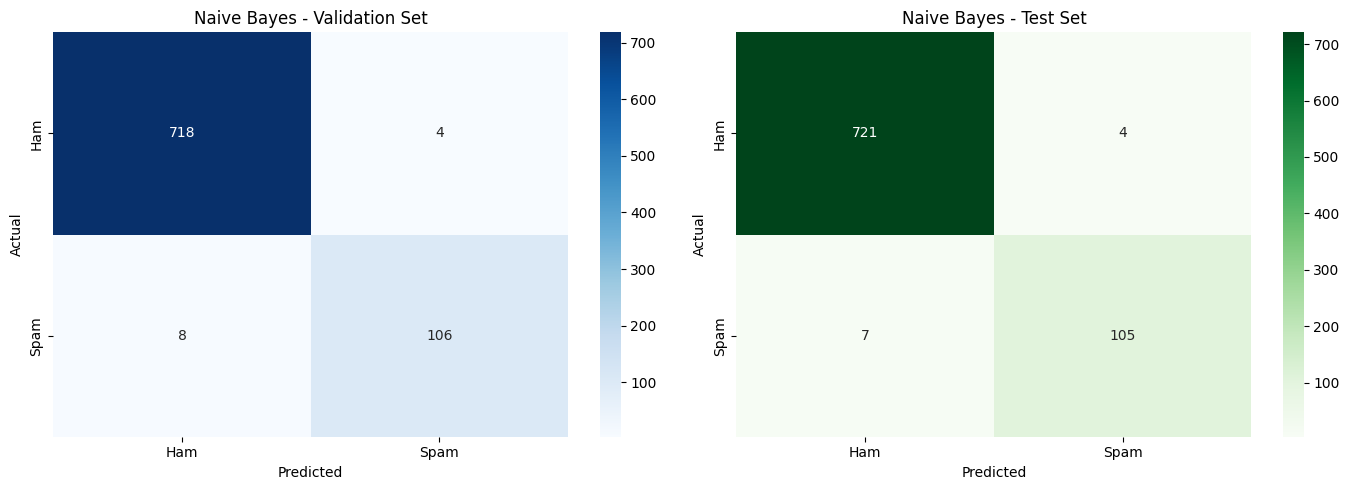

In [9]:
# --- Train and Validate ---
nb_classifier, vectorizer, train_stats, val_stats = run_validation(
    train_df['message'], 
    train_df['label'], 
    val_df['message'], 
    val_df['label']
)

print("--- Baseline Naive Bayes Results ---")
print(f"Train Accuracy:      {train_stats['accuracy']:.4f}")
print(f"Validation Accuracy: {val_stats['accuracy']:.4f}")
print("-" * 30)
print(f"Precision: {val_stats['precision']:.4f}")
print(f"Recall:    {val_stats['recall']:.4f}")
print(f"F1 Score:  {val_stats['f1']:.4f}")
print("-" * 30)

# --- Add Confusion Matrix Visualization ---

# Generate predictions for plotting
val_preds = nb_classifier.predict(vectorizer.transform(val_df['message']))
test_preds = nb_classifier.predict(vectorizer.transform(test_df['message']))

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Validation Confusion Matrix
cm_val = confusion_matrix(val_df['label'], val_preds)
sns.heatmap(
    cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
axes[0].set_title('Naive Bayes - Validation Set')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot Test Confusion Matrix
cm_test = confusion_matrix(test_df['label'], test_preds)
sns.heatmap(
    cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
axes[1].set_title('Naive Bayes - Test Set')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

--- Starting Hyperparameter Tuning ---
Best Parameters Found: {'nb__alpha': 0.5}

Tuned Naive Bayes - Validation Results:
{'precision': 0.9473684210526315, 'recall': 0.9473684210526315, 'f1': 0.9473684210526315, 'accuracy': 0.9856459330143541}


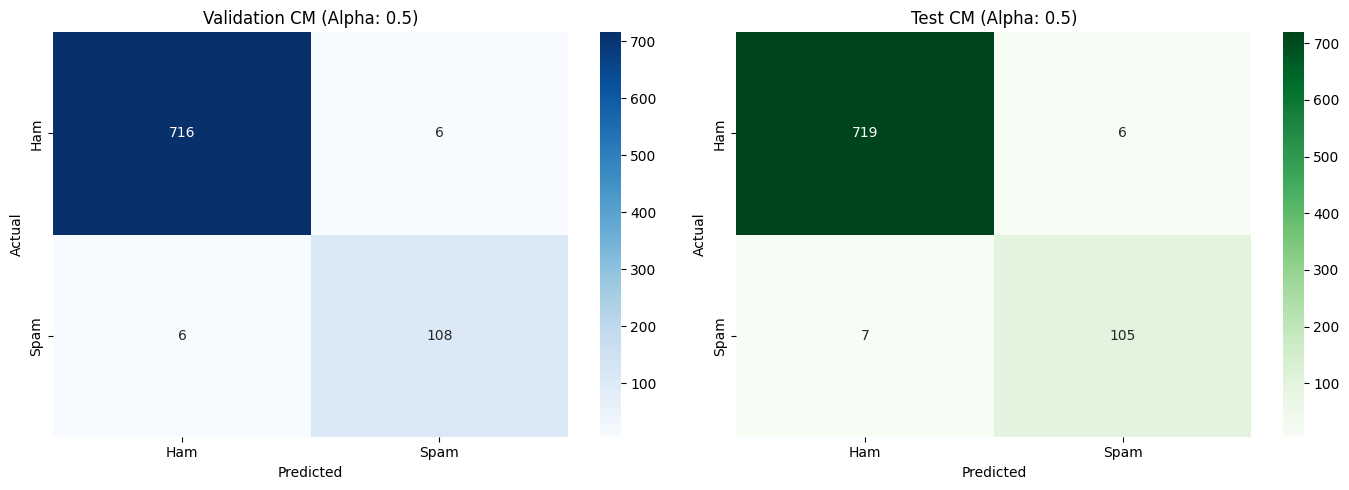

In [10]:
from sklearn.pipeline import Pipeline

def optimize_hyperparameters(train_text, train_labels):
    """
    Uses GridSearchCV to find the best 'alpha' for Naive Bayes.
    Returns the best model pipeline and parameters.
    """
    # Create a pipeline (Vectorizer + Classifier)
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('nb', MultinomialNB())
    ])
    
    # Define parameters to test (alpha controls smoothing)
    param_grid = {
        'nb__alpha': [0.1, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
    }
    
    # Run Grid Search (5-fold cross-validation)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(train_text, train_labels)
    
    return grid_search.best_estimator_, grid_search.best_params_

print("--- Starting Hyperparameter Tuning ---")
best_model_pipeline, best_params = optimize_hyperparameters(train_df['message'], train_df['label'])

print(f"Best Parameters Found: {best_params}")

# Extract the best vectorizer and classifier from the pipeline to use our helper functions
best_cv = best_model_pipeline.named_steps['vect']
best_clf = best_model_pipeline.named_steps['nb']

# Evaluate the tuned model on Validation data
val_preds, val_acc = prediction_metrics(best_clf, best_cv, val_df['message'], val_df['label'])
val_stats = performance_metrics(val_df['label'], val_preds)
val_stats['accuracy'] = val_acc

print("\nTuned Naive Bayes - Validation Results:")
print(val_stats)


# Generate predictions for the Test set
test_preds, test_acc = prediction_metrics(best_clf, best_cv, test_df['message'], test_df['label'])

# Setup the plot area (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Plot Validation Confusion Matrix
cm_val = confusion_matrix(val_df['label'], val_preds)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_title(f"Validation CM (Alpha: {best_params['nb__alpha']})")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Plot Test Confusion Matrix
cm_test = confusion_matrix(test_df['label'], test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_title(f"Test CM (Alpha: {best_params['nb__alpha']})")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

--- Baseline Random Forest (Default) Results ---
Validation Accuracy: 0.9713
F1 Score: 0.8824
----------------------------------------


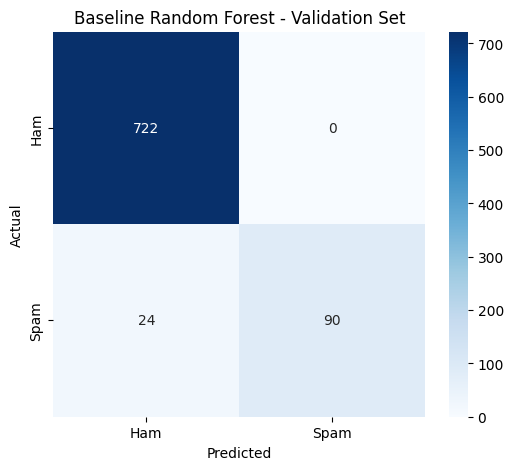

In [13]:
# 1. Initialize Vectorizer
rf_cv_simple = CountVectorizer()
train_features_rf = rf_cv_simple.fit_transform(train_df['message'])

# 2. Initialize and Fit Random Forest with Default Parameters
rf_clf_simple = RandomForestClassifier(random_state=42)
rf_clf_simple.fit(train_features_rf, train_df['label'])

# 3. Evaluate on Validation Data
# We use your helper functions 'prediction_metrics' and 'performance_metrics'
val_preds_simple, val_acc_simple = prediction_metrics(rf_clf_simple, rf_cv_simple, val_df['message'], val_df['label'])
val_stats_simple = performance_metrics(val_df['label'], val_preds_simple)
val_stats_simple['accuracy'] = val_acc_simple

print("--- Baseline Random Forest (Default) Results ---")
print(f"Validation Accuracy: {val_stats_simple['accuracy']:.4f}")
print(f"F1 Score: {val_stats_simple['f1']:.4f}")
print("-" * 40)

# 4. Plot Confusion Matrix for Baseline Random Forest
fig, ax = plt.subplots(figsize=(6, 5))
cm_simple = confusion_matrix(val_df['label'], val_preds_simple)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
ax.set_title('Baseline Random Forest - Validation Set')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

--- Starting Random Forest Hyperparameter Tuning ---
Best Parameters Found: {'rf__max_depth': None, 'rf__n_estimators': 100}

Tuned Random Forest - Validation Results:
{'precision': 1.0, 'recall': 0.7894736842105263, 'f1': 0.8823529411764706, 'accuracy': 0.9712918660287081}


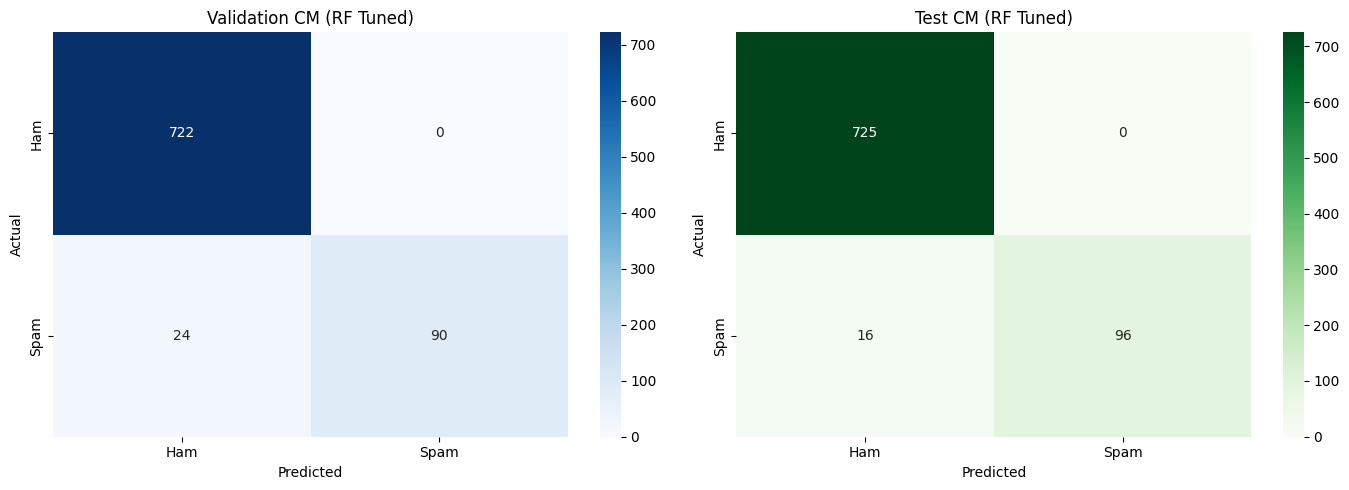

In [12]:
def optimize_rf_hyperparameters(train_text, train_labels):
    """
    Uses GridSearchCV to find the best hyperparameters for Random Forest.
    Returns the best model pipeline and parameters.
    """
    # Create a pipeline (Vectorizer + Classifier)
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
    ])
    
    # Define parameters to test
    # n_estimators: Number of trees
    # max_depth: Maximum depth of the tree (None = full depth)
    param_grid = {
        'rf__n_estimators': [50, 100, 200],
        'rf__max_depth': [None, 10, 20]
    }
    
    # Run Grid Search (5-fold cross-validation)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(train_text, train_labels)
    
    return grid_search.best_estimator_, grid_search.best_params_

print("--- Starting Random Forest Hyperparameter Tuning ---")
best_rf_pipeline, best_rf_params = optimize_rf_hyperparameters(train_df['message'], train_df['label'])

print(f"Best Parameters Found: {best_rf_params}")

# Extract the best vectorizer and classifier from the pipeline
best_rf_cv = best_rf_pipeline.named_steps['vect']
best_rf_clf = best_rf_pipeline.named_steps['rf']

# Evaluate the tuned model on Validation data
val_preds, val_acc = prediction_metrics(best_rf_clf, best_rf_cv, val_df['message'], val_df['label'])
val_stats = performance_metrics(val_df['label'], val_preds)
val_stats['accuracy'] = val_acc

print("\nTuned Random Forest - Validation Results:")
print(val_stats)

# Generate predictions for the Test set
test_preds, test_acc = prediction_metrics(best_rf_clf, best_rf_cv, test_df['message'], test_df['label'])

# Setup the plot area (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Plot Validation Confusion Matrix
cm_val = confusion_matrix(val_df['label'], val_preds)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_title(f"Validation CM (RF Tuned)")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Plot Test Confusion Matrix
cm_test = confusion_matrix(test_df['label'], test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_title(f"Test CM (RF Tuned)")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

--- Baseline Logistic Regression (Default) Results ---
Validation Accuracy: 0.9833
F1 Score: 0.9352
----------------------------------------


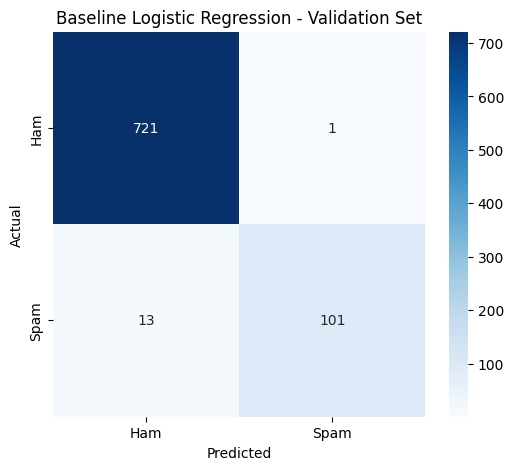

In [14]:
# 1. Initialize Vectorizer
lr_cv_simple = CountVectorizer()
train_features_lr = lr_cv_simple.fit_transform(train_df['message'])

# 2. Initialize and Fit Logistic Regression with Default Parameters
# We increase max_iter to 1000 to ensure convergence, but keep other params default
lr_clf_simple = LogisticRegression(random_state=42, max_iter=1000)
lr_clf_simple.fit(train_features_lr, train_df['label'])

# 3. Evaluate on Validation Data
# We use your helper functions 'prediction_metrics' and 'performance_metrics'
val_preds_simple, val_acc_simple = prediction_metrics(lr_clf_simple, lr_cv_simple, val_df['message'], val_df['label'])
val_stats_simple = performance_metrics(val_df['label'], val_preds_simple)
val_stats_simple['accuracy'] = val_acc_simple

print("--- Baseline Logistic Regression (Default) Results ---")
print(f"Validation Accuracy: {val_stats_simple['accuracy']:.4f}")
print(f"F1 Score: {val_stats_simple['f1']:.4f}")
print("-" * 40)

# 4. Plot Confusion Matrix for Baseline Logistic Regression
fig, ax = plt.subplots(figsize=(6, 5))
cm_simple = confusion_matrix(val_df['label'], val_preds_simple)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
ax.set_title('Baseline Logistic Regression - Validation Set')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

--- Starting Logistic Regression Hyperparameter Tuning ---
Best Parameters Found: {'lr__C': 100.0}

Tuned Logistic Regression - Validation Results:
{'precision': 0.9905660377358491, 'recall': 0.9210526315789473, 'f1': 0.9545454545454546, 'accuracy': 0.9880382775119617}


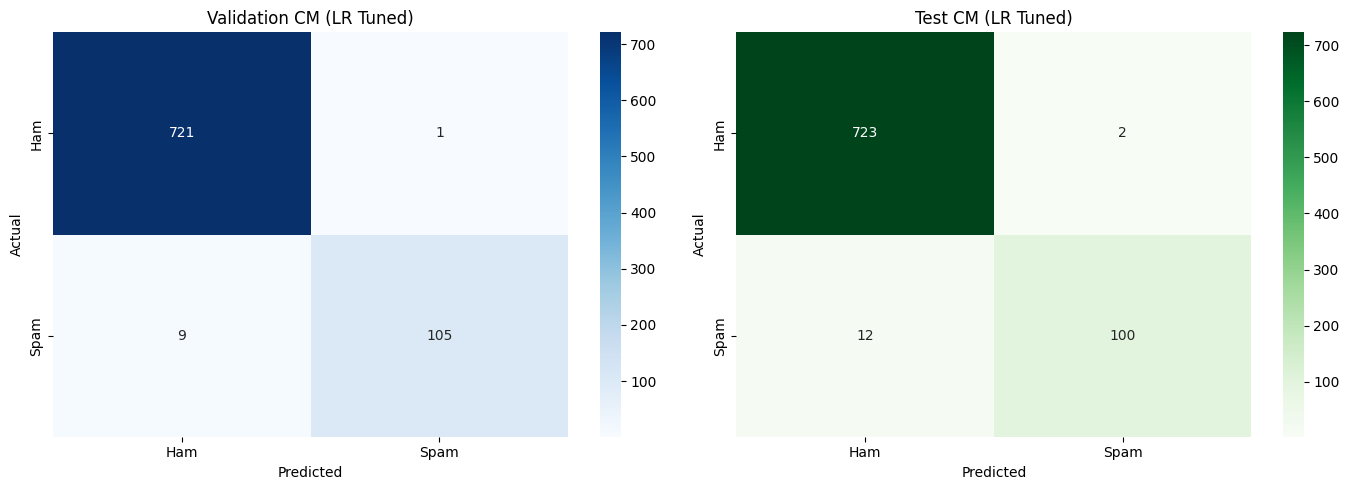

In [15]:
def optimize_lr_hyperparameters(train_text, train_labels):
    """
    Uses GridSearchCV to find the best hyperparameters for Logistic Regression.
    Returns the best model pipeline and parameters.
    """
    # Create a pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    # Define parameters to test
    # C: Inverse of regularization strength (smaller = stronger regularization)
    param_grid = {
        'lr__C': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
    
    # Run Grid Search (5-fold cross-validation)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(train_text, train_labels)
    
    return grid_search.best_estimator_, grid_search.best_params_

print("--- Starting Logistic Regression Hyperparameter Tuning ---")
best_lr_pipeline, best_lr_params = optimize_lr_hyperparameters(train_df['message'], train_df['label'])

print(f"Best Parameters Found: {best_lr_params}")

# Extract the best vectorizer and classifier
best_lr_cv = best_lr_pipeline.named_steps['vect']
best_lr_clf = best_lr_pipeline.named_steps['lr']

# Evaluate on Validation data
val_preds, val_acc = prediction_metrics(best_lr_clf, best_lr_cv, val_df['message'], val_df['label'])
val_stats = performance_metrics(val_df['label'], val_preds)
val_stats['accuracy'] = val_acc

print("\nTuned Logistic Regression - Validation Results:")
print(val_stats)

# Generate predictions for the Test set
test_preds, test_acc = prediction_metrics(best_lr_clf, best_lr_cv, test_df['message'], test_df['label'])

# Setup the plot area (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Plot Validation Confusion Matrix
cm_val = confusion_matrix(val_df['label'], val_preds)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[0].set_title(f"Validation CM (LR Tuned)")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Plot Test Confusion Matrix
cm_test = confusion_matrix(test_df['label'], test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
axes[1].set_title(f"Test CM (LR Tuned)")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [16]:
def evaluate_benchmark_models(train_df, val_df, test_df):
    # 1. Define the models to compare
    models = {
        "Naive Bayes": MultinomialNB(alpha=0.5), # Using the tuned alpha from previous step
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    results = []
    trained_models = {}
    
    # Initialize Vectorizer once for consistency
    cv = CountVectorizer()
    X_train = cv.fit_transform(train_df['message'])
    X_test = cv.transform(test_df['message'])
    y_train = train_df['label']
    y_test = test_df['label']

    print(f"{'Model':<25} | {'Accuracy':<10} | {'F1 Score':<10}")
    print("-" * 50)

    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Get predictions and metrics on TEST data
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        metrics = performance_metrics(y_test, preds)
        
        results.append({
            "model_name": name,
            "accuracy": acc,
            "f1": metrics['f1'],
            "metrics": metrics
        })
        
        print(f"{name:<25} | {acc:<10.4f} | {metrics['f1']:<10.4f}")

    # 2. Select the best model based on F1 Score
    best_model_info = max(results, key=lambda x: x['f1'])
    
    print("-" * 50)
    print(f"WINNER: {best_model_info['model_name']} is the best model!")
    print(f"Final Test F1-Score: {best_model_info['f1']:.4f}")
    
    return best_model_info

# Execute the comparison
best_model = evaluate_benchmark_models(train_df, val_df, test_df)

Model                     | Accuracy   | F1 Score  
--------------------------------------------------
Naive Bayes               | 0.9845     | 0.9417    
Logistic Regression       | 0.9797     | 0.9194    
Random Forest             | 0.9809     | 0.9231    
--------------------------------------------------
WINNER: Naive Bayes is the best model!
Final Test F1-Score: 0.9417
